**Pattern Recognition Project 1**

by Amir Mahdi Nikukaran

ID: 99722148

# **Text Sentiment Recognition**

  The main aim of this project is evaluate some base classifiers in sentiment recognition task. This project is done with four word embedding approaches (BOW, TF-IDF, Word2Vec and BERT) and three base classifiers (Naive Bayes, Linear SVM and SVM with RBF kernel) as well as some text pre-processing techniques on the IMDB movie reviews dataset.

  IMDB movie reviews dataset contains 50K reviews, half of which are positive and the other half negative. The dataset has splitted to 40K training set, 5K validation set and 5K testing set.



In [1]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
train_id = '1VPbM-txlbNAWM1K0h3XKVJEkTE8bYgTz'
valid_id = '1-uxpBcpItwLCkWdXX3MsVWL2iO2DvrNP'
test_id = '1g8pz76ZAxufftkHzy1g1W7EPVZhdSGKM'

In [3]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.sklearn_api import W2VTransformer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import GridSearchCV

from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, plot_roc_curve, roc_auc_score

import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')

In [4]:
downloaded = drive.CreateFile({'id':train_id})
downloaded.GetContentFile('Train.csv')
train_df = pd.read_csv('Train.csv')# Dataset is now stored in a Pandas Dataframe

downloaded = drive.CreateFile({'id':valid_id})
downloaded.GetContentFile('Valid.csv')
valid_df = pd.read_csv('Valid.csv')# Dataset is now stored in a Pandas Dataframe

downloaded = drive.CreateFile({'id':test_id})
downloaded.GetContentFile('Test.csv')
test_df = pd.read_csv('Test.csv')# Dataset is now stored in a Pandas Dataframe

In [5]:
print(train_df.shape)
train_df[:10]

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [6]:
print(valid_df.shape)
valid_df[:10]

(5000, 2)


,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0
5,This is the best movie I've ever seen! <br /><...,1
6,The morbid Catholic writer Gerard Reve (Jeroen...,1
7,"""Semana Santa"" or ""Angel Of Death"" is a very w...",0
8,Somebody mastered the difficult task of mergin...,1
9,Why did I waste 1.5 hours of my life watching ...,0


In [7]:
print(test_df.shape)
test_df[:10]

(5000, 2)


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
5,"I saw this film on September 1st, 2005 in Indi...",1
6,I saw a screening of this movie last night. I ...,0
7,William Hurt may not be an American matinee id...,1
8,IT IS A PIECE OF CRAP! not funny at all. durin...,0
9,I'M BOUT IT(1997)<br /><br />Developed & publi...,0


In [8]:
train_df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
valid_df.describe()

,label
count,5000.000000
mean,0.502800
std,0.500042
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
test_df.describe()

,label
count,5000.000000
mean,0.501000
std,0.500049
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Pre-Processing Dataset



  Since this dataset scraped from the web, some HTML codes got mixed up with it. So, cleaning up these texts by removing HTML tags (by BeautifulSoup) is required. Removing numbers, punctuations, and stop words (by NLTK stop words set) would be beneficial. Also lemmatization is used.


In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [13]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
train_df['text'] = train_df['text'].apply(denoise_text)
valid_df['text'] = valid_df['text'].apply(denoise_text)
test_df['text'] = test_df['text'].apply(denoise_text)

In [14]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text = re.sub(r"[0-9]+", ' ', text)
    text = re.sub(r"-", ' ', text)
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
train_df['text'] = train_df['text'].apply(remove_special_characters)
valid_df['text'] = valid_df['text'].apply(remove_special_characters)
test_df['text'] = test_df['text'].apply(remove_special_characters)

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
#lemmatizing the text
def simple_lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = ' '.join([wn.lemmatize(word) for word in text.split()])
    return text

#Apply function on review column
train_df['text'] = train_df['text'].apply(simple_lemmatizer)
valid_df['text'] = valid_df['text'].apply(simple_lemmatizer)
test_df['text'] = test_df['text'].apply(simple_lemmatizer)

In [18]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
train_df['text'] = train_df['text'].apply(remove_stopwords)
valid_df['text'] = valid_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)

{"weren't", 'with', 'nor', 'isn', 'again', 'himself', 'how', 'who', 'hers', 'needn', 'their', "should've", 'what', 'which', "don't", 'them', 'herself', "shouldn't", 'down', "wouldn't", "aren't", "doesn't", 'wouldn', 'then', 'should', 'it', 'whom', 'to', 'd', 'up', 'him', 'this', 'myself', 'once', 'those', 'after', 'because', 'on', 'where', 'there', 'was', 're', 'me', 'our', 'wasn', 'y', 'shan', "you've", 'haven', 'being', "isn't", 'until', 'my', 'yours', 'during', 've', 'm', 'here', "that'll", 'by', 'below', 'yourself', 'mightn', 'just', "mustn't", 'the', 'from', "shan't", "haven't", 'won', 'ourselves', 'theirs', 'but', 'each', 'out', 'been', 'when', 'most', 'aren', 'had', "won't", 'he', 'between', 'more', 'her', 'now', 'ma', 'and', 'his', 'under', 'a', 'for', 'own', 'having', 'its', 'very', 'o', "mightn't", 'other', 'in', 'your', 'off', 'while', 'at', "you'll", 'about', 'has', 'shouldn', 'why', 'any', 'yourselves', 'over', 'these', 't', 'they', 'through', 'themselves', "you'd", 'as', 

In [19]:
train_df[:10]

,text,label
0,grew b watching loving Thunderbirds mate schoo...,0
1,put movie DVD player sat coke chip expectation...,0
2,people know particular time past wa like feel ...,0
3,Even though great interest Biblical movie wa b...,0
4,Im die hard Dads Army fan nothing ever change ...,1
5,terrible movie everyone ha said made laugh wa ...,0
6,Finally watched shocking movie last night dist...,1
7,caught film AZN cable sounded like would good ...,0
8,may remake Autumns Tale eleven year director M...,1
9,Super Ex Girlfriend turned pleasant surprise w...,1


In [20]:
valid_df[:10]

,text,label
0,year since Sharon Stone awarded viewer leg cro...,0
1,someone needed make car payment truly awful ma...,0
2,Guidelines state comment must contain minimum ...,0
3,movie muddled mish mash clichs recent cinema p...,0
4,Stan Laurel became smaller half time greatest ...,0
5,best movie Ive ever seen Maybe live mile villa...,1
6,morbid Catholic writer Gerard Reve Jeroen Krab...,1
7,Semana Santa Angel Death weak movie Mira Sorvi...,0
8,Somebody mastered difficult task merging sport...,1
9,waste hour life watching wa film even made eve...,0


In [21]:
test_df[:10]

,text,label
0,always wrote series complete stink fest Jim Be...,0
1,st watched Dir Steve Purcell Typical Mary Kate...,0
2,movie wa poorly written directed fell asleep m...,0
3,interesting thing Miryang Secret Sunshine acto...,1
4,first read berlin meer didnt expect much thoug...,0
5,saw film September st Indianapolis one judge H...,1
6,saw screening movie last night high expectatio...,0
7,William Hurt may American matinee idol anymore...,1
8,PIECE CRAP funny whole movie nothing ever happ...,0
9,IM BOUT Developed published Limit FilmsPros Ab...,0


# BOW and TF-IDF

**BOW:**

  In this approach, we make a list of all the unique words in training data called the vocabulary. then, given an input text, we create a fixed numerical vector that counts each word of the vocabulary. To use BOW embedding in Python, we can use the CountVectorizer function from the scikit-learn library.

**TF-IDF:**

  The tf–idf is the product of two statistics, frequency of x in y and logarithm for the product of total number of documents and inverse number of documents containing x.

  Despite the simplicity and low time complexity, BOW and TF-IDF have two major drawbacks. First, as the size of the data and the number of unique words in the training text increases, their length of vectors becomes much larger. Moreover, in these two approaches, only words and their repetitions are important and the order of the words in the text will not be considered in the model. Hence, we have considered both Word2Vec and BERT embedding approaches to our experiments.


## Naive Bayes

In [22]:
#Count vectorizer for bag of words
NB_cv = CountVectorizer(binary=False, max_features=6000)

#transformed train reviews
NB_cv_train_reviews = NB_cv.fit_transform(train_df['text'])
#transformed valid reviews
#NB_cv_valid_reviews = NB_cv.fit_transform(valid_df['text'])
#transformed test reviews
NB_cv_test_reviews = NB_cv.transform(test_df['text'])

print('NB_BOW_cv_train:', NB_cv_train_reviews.shape)
#print('NB_BOW_cv_valid:', NB_cv_valid_reviews.shape)
print('NB_BOW_cv_test:', NB_cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

NB_BOW_cv_train: (40000, 6000)
NB_BOW_cv_test: (5000, 6000)


In [23]:
#Tfidf vectorizer
NB_tv = TfidfVectorizer(max_features=6000)

#transformed train reviews
NB_tv_train_reviews=NB_tv.fit_transform(train_df['text'])
#transformed valid reviews
#NB_tv_valid_reviews = NB_tv.fit_transform(valid_df['text'])
#transformed test reviews
NB_tv_test_reviews=NB_tv.transform(test_df['text'])

print('Tfidf_train:',NB_tv_train_reviews.shape)
#print('Tfidf_valid:',NB_tv_valid_reviews.shape)
print('Tfidf_test:',NB_tv_test_reviews.shape)

Tfidf_train: (40000, 6000)
Tfidf_test: (5000, 6000)


In [24]:
#training the model
bnb = BernoulliNB()

#fitting the model for bag of words
bnb_bow = bnb.fit(NB_cv_train_reviews.toarray(), train_df['label'])
print(bnb_bow)

#fitting the model for tfidf features
bnb_tfidf = bnb.fit(NB_tv_train_reviews.toarray(), train_df['label'])
print(bnb_tfidf)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [25]:
#Predicting the model for bag of words
bnb_bow_predict = bnb.predict(NB_cv_test_reviews.toarray())
print(bnb_bow_predict)

#Predicting the model for tfidf features
bnb_tfidf_predict = bnb.predict(NB_tv_test_reviews.toarray())
print(bnb_tfidf_predict)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


In [26]:
#Accuracy score for bag of words
bnb_bow_score = accuracy_score(test_df['label'], bnb_bow_predict)
print("bnb_bow_score :",bnb_bow_score)

#Accuracy score for tfidf features
bnb_tfidf_score = accuracy_score(test_df['label'], bnb_tfidf_predict)
print("bnb_tfidf_score :",bnb_tfidf_score)
'''
7000:
bnb_bow_score : 0.8582
bnb_tfidf_score : 0.8582
6000:
bnb_bow_score : 0.8622
bnb_tfidf_score : 0.8622
5000:
bnb_bow_score : 0.86
bnb_tfidf_score : 0.86
'''

bnb_bow_score : 0.857
bnb_tfidf_score : 0.857


'\n7000:\nbnb_bow_score : 0.8582\nbnb_tfidf_score : 0.8582\n6000:\nbnb_bow_score : 0.8622\nbnb_tfidf_score : 0.8622\n5000:\nbnb_bow_score : 0.86\nbnb_tfidf_score : 0.86\n'

In [27]:
#Classification report for bag of words 
bnb_bow_report = classification_report(test_df['label'], bnb_bow_predict, target_names=['Positive', 'Negative'])
print(bnb_bow_report)

#Classification report for tfidf features
bnb_tfidf_report = classification_report(test_df['label'], bnb_tfidf_predict, target_names=['Positive', 'Negative'])
print(bnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.86      0.86      0.86      2495
    Negative       0.86      0.86      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

              precision    recall  f1-score   support

    Positive       0.86      0.86      0.86      2495
    Negative       0.86      0.86      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [28]:
#confusion matrix for bag of words
bnb_cm_bow = confusion_matrix(test_df['label'], bnb_bow_predict, labels=[1,0])
print(bnb_cm_bow)

#confusion matrix for tfidf features
bnb_cm_tfidf = confusion_matrix(test_df['label'], bnb_tfidf_predict, labels=[1,0])
print(bnb_cm_tfidf)

[[2145  360]
 [ 355 2140]]
[[2145  360]
 [ 355 2140]]


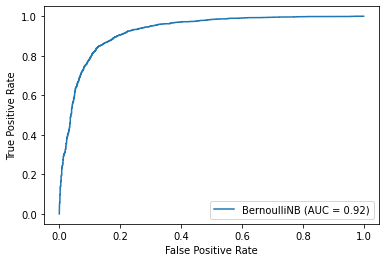

In [29]:
# BOW
plot_roc_curve(bnb_bow, NB_cv_test_reviews.toarray(), test_df['label'])

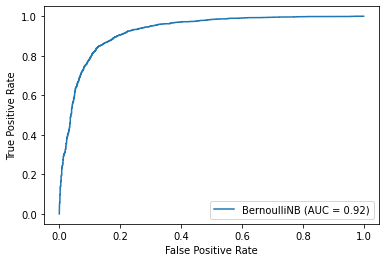

In [30]:
# TFIDF
plot_roc_curve(bnb_tfidf, NB_tv_test_reviews.toarray(), test_df['label'])

## Linear SVM

In [31]:
#Count vectorizer for bag of words
Linear_SVM_cv = CountVectorizer(binary=False, max_features=6000)

#transformed train reviews
Linear_SVM_cv_train_reviews = Linear_SVM_cv.fit_transform(train_df['text'])
#transformed valid reviews
#Linear_SVM_cv_valid_reviews = Linear_SVM_cv.fit_transform(valid_df['text'])
#transformed test reviews
Linear_SVM_cv_test_reviews = Linear_SVM_cv.transform(test_df['text'])

print('Linear_SVM_BOW_cv_train:', Linear_SVM_cv_train_reviews.shape)
#print('Linear_SVM_BOW_cv_valid:', Linear_SVM_cv_valid_reviews.shape)
print('Linear_SVM_BOW_cv_test:', Linear_SVM_cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

Linear_SVM_BOW_cv_train: (40000, 6000)
Linear_SVM_BOW_cv_test: (5000, 6000)


In [32]:
#Tfidf vectorizer
Linear_SVM_tv = TfidfVectorizer(max_features=6000)

#transformed train reviews
Linear_SVM_tv_train_reviews=Linear_SVM_tv.fit_transform(train_df['text'])
#transformed valid reviews
#Linear_SVM_tv_valid_reviews = Linear_SVM_tv.fit_transform(valid_df['text'])
#transformed test reviews
Linear_SVM_tv_test_reviews=Linear_SVM_tv.transform(test_df['text'])

print('Tfidf_train:',Linear_SVM_tv_train_reviews.shape)
#print('Tfidf_valid:',Linear_SVM_tv_valid_reviews.shape)
print('Tfidf_test:',Linear_SVM_tv_test_reviews.shape)

Tfidf_train: (40000, 6000)
Tfidf_test: (5000, 6000)


In [33]:
#training the model
svm_linear = LinearSVC(verbose=1, max_iter=5000, loss='hinge')

#fitting the model for bag of words
svm_linear_bow = svm_linear.fit(Linear_SVM_cv_train_reviews,train_df['label'])
print(svm_linear_bow)

#fitting the model for tfidf features
svm_linear_tfidf = svm_linear.fit(Linear_SVM_tv_train_reviews,train_df['label'])
print(svm_linear_tfidf)

[LibLinear]LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=1)
[LibLinear]LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=1)


In [34]:
#Predicting the model for bag of words
svm_linear_bow_predict = svm_linear.predict(Linear_SVM_cv_test_reviews)
print(svm_linear_bow_predict)

#Predicting the model for tfidf features
svm_linear_tfidf_predict = svm_linear.predict(Linear_SVM_tv_test_reviews)
print(svm_linear_tfidf_predict)

[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


In [35]:
#Accuracy score for bag of words
svm_linear_bow_score = accuracy_score(test_df['label'], svm_linear_bow_predict)
print("svm_linear_bow_score :",svm_linear_bow_score)

#Accuracy score for tfidf features
svm_linear_tfidf_score = accuracy_score(test_df['label'], svm_linear_tfidf_predict)
print("svm_linear_tfidf_score :",svm_linear_tfidf_score)
'''
1500:
svm_linear_bow_score : 0.8378
svm_linear_tfidf_score : 0.8424
2500:
svm_linear_bow_score : 0.8434
svm_linear_tfidf_score : 0.8506
3500:
svm_linear_bow_score : 0.8416
svm_linear_tfidf_score : 0.8558
4500:
svm_linear_bow_score : 0.8454
svm_linear_tfidf_score : 0.8556
'''

svm_linear_bow_score : 0.876
svm_linear_tfidf_score : 0.8856


'\n1500:\nsvm_linear_bow_score : 0.8378\nsvm_linear_tfidf_score : 0.8424\n2500:\nsvm_linear_bow_score : 0.8434\nsvm_linear_tfidf_score : 0.8506\n3500:\nsvm_linear_bow_score : 0.8416\nsvm_linear_tfidf_score : 0.8558\n4500:\nsvm_linear_bow_score : 0.8454\nsvm_linear_tfidf_score : 0.8556\n'

In [36]:
#Classification report for bag of words 
svm_linear_bow_report = classification_report(test_df['label'], svm_linear_bow_predict, target_names=['Positive', 'Negative'])
print(svm_linear_bow_report)

#Classification report for tfidf features
svm_linear_tfidf_report = classification_report(test_df['label'], svm_linear_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_linear_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.90      0.84      0.87      2495
    Negative       0.85      0.91      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.88      2495
    Negative       0.88      0.89      0.89      2505

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



In [37]:
#confusion matrix for bag of words
svm_linear_cm_bow = confusion_matrix(test_df['label'], svm_linear_bow_predict, labels=[1,0])
print(svm_linear_cm_bow)

#confusion matrix for tfidf features
svm_linear_cm_tfidf = confusion_matrix(test_df['label'], svm_linear_tfidf_predict, labels=[1,0])
print(svm_linear_cm_tfidf)

[[2272  233]
 [ 387 2108]]
[[2236  269]
 [ 303 2192]]


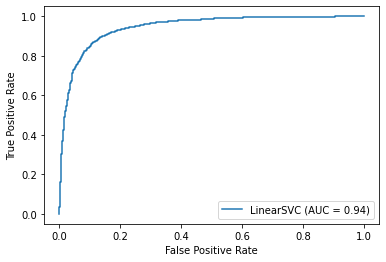

In [38]:
# BOW
plot_roc_curve(svm_linear_bow, Linear_SVM_cv_test_reviews.toarray(), test_df['label'])

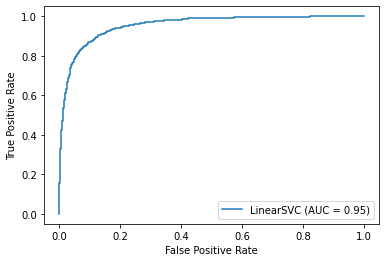

In [39]:
# TFIDF
plot_roc_curve(svm_linear_tfidf, Linear_SVM_tv_test_reviews.toarray(), test_df['label'])

## SVM with RBF kernel

In [40]:
#Count vectorizer for bag of words
RBF_SVM_cv = CountVectorizer(binary=False, max_features=6000)

#transformed train reviews
RBF_SVM_cv_train_reviews = RBF_SVM_cv.fit_transform(train_df['text'])
#transformed valid reviews
RBF_SVM_cv_valid_reviews = RBF_SVM_cv.fit_transform(valid_df['text'])
#transformed test reviews
RBF_SVM_cv_test_reviews = RBF_SVM_cv.transform(test_df['text'])

print('RBF_SVM_BOW_cv_train:', RBF_SVM_cv_train_reviews.shape)
print('RBF_SVM_BOW_cv_valid:', RBF_SVM_cv_valid_reviews.shape)
print('RBF_SVM_BOW_cv_test:', RBF_SVM_cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

RBF_SVM_BOW_cv_train: (40000, 6000)
RBF_SVM_BOW_cv_valid: (5000, 6000)
RBF_SVM_BOW_cv_test: (5000, 6000)


In [41]:
#Tfidf vectorizer
RBF_SVM_tv = TfidfVectorizer(max_features=6000)

#transformed train reviews
RBF_SVM_tv_train_reviews=RBF_SVM_tv.fit_transform(train_df['text'])
#transformed valid reviews
RBF_SVM_tv_valid_reviews = RBF_SVM_tv.fit_transform(valid_df['text'])
#transformed test reviews
RBF_SVM_tv_test_reviews=RBF_SVM_tv.transform(test_df['text'])

print('Tfidf_train:',RBF_SVM_tv_train_reviews.shape)
print('Tfidf_valid:',RBF_SVM_tv_valid_reviews.shape)
print('Tfidf_test:',RBF_SVM_tv_test_reviews.shape)

Tfidf_train: (40000, 6000)
Tfidf_valid: (5000, 6000)
Tfidf_test: (5000, 6000)


In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
svm_rbf = SVC(kernel='rbf', verbose=True, probability=True)

rbf_parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001]
    }

rbf_grid = GridSearchCV(svm_rbf, rbf_parameters, refit = True, verbose = 3) 

# fitting the model for grid search 
rbf_grid.fit(RBF_SVM_cv_valid_reviews, valid_df['label']) 

print_results(rbf_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=1, gamma=0.1, score=0.596, total=  48.3s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.3s remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.639, total=  48.1s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.588, total=  47.7s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.572, total=  47.6s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.546, total=  47.8s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.798, total=  38.9s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.820, total=  38.7s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.807, total=  38.5s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.821, total=  38.3s
[CV] C=1, gamma=0.01 ........

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 48.8min finished


BEST PARAMS: {'C': 10, 'gamma': 0.001}

0.588 (+/-0.061) for {'C': 1, 'gamma': 0.1}
0.81 (+/-0.018) for {'C': 1, 'gamma': 0.01}
0.805 (+/-0.019) for {'C': 1, 'gamma': 0.001}
0.67 (+/-0.02) for {'C': 1, 'gamma': 0.0001}
0.611 (+/-0.056) for {'C': 10, 'gamma': 0.1}
0.808 (+/-0.007) for {'C': 10, 'gamma': 0.01}
0.825 (+/-0.014) for {'C': 10, 'gamma': 0.001}
0.809 (+/-0.026) for {'C': 10, 'gamma': 0.0001}
0.611 (+/-0.056) for {'C': 100, 'gamma': 0.1}
0.801 (+/-0.005) for {'C': 100, 'gamma': 0.01}
0.813 (+/-0.025) for {'C': 100, 'gamma': 0.001}
0.823 (+/-0.021) for {'C': 100, 'gamma': 0.0001}
0.611 (+/-0.056) for {'C': 1000, 'gamma': 0.1}
0.801 (+/-0.005) for {'C': 1000, 'gamma': 0.01}
0.783 (+/-0.019) for {'C': 1000, 'gamma': 0.001}
0.807 (+/-0.019) for {'C': 1000, 'gamma': 0.0001}


In [ ]:
# print best parameter after tuning 
print(rbf_grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(rbf_grid.best_estimator_) 

{'C': 10, 'gamma': 0.001}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)


In [ ]:
'''
rbf_grid = GridSearchCV(svm_rbf, rbf_parameters, refit = True, verbose = 3) 

# fitting the model for grid search 
rbf_grid.fit(RBF_SVM_tv_valid_reviews, valid_df['label']) 

print_results(rbf_grid)
'''

In [ ]:
grid_predictions = rbf_grid.predict(RBF_SVM_cv_test_reviews) 
  
# print classification report 
print(classification_report(test_df['label'], grid_predictions)) 

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      2495
           1       0.82      0.85      0.84      2505

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [42]:
#training the model
svm_rbf = SVC(kernel='rbf', verbose=True, C=10, gamma=0.001)

#fitting the model for bag of words
svm_rbf_bow = svm_rbf.fit(RBF_SVM_cv_train_reviews,train_df['label'])
print(svm_rbf_bow)

#fitting the model for tfidf features
svm_rbf_tfidf = svm_rbf.fit(RBF_SVM_tv_train_reviews,train_df['label'])
print(svm_rbf_tfidf)

[LibSVM]SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM]SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)


In [43]:
#Predicting the model for bag of words
svm_rbf_bow_predict = svm_rbf.predict(RBF_SVM_cv_test_reviews)
print(svm_rbf_bow_predict)

#Predicting the model for tfidf features
svm_rbf_tfidf_predict = svm_rbf.predict(RBF_SVM_tv_test_reviews)
print(svm_rbf_tfidf_predict)

[0 1 1 ... 1 0 1]
[1 1 1 ... 1 1 1]


In [44]:
#Accuracy score for bag of words
svm_rbf_bow_score = accuracy_score(test_df['label'], svm_rbf_bow_predict)
print("svm_rbf_bow_score :",svm_rbf_bow_score)

#Accuracy score for tfidf features
svm_rbf_tfidf_score = accuracy_score(test_df['label'], svm_rbf_tfidf_predict)
print("svm_rbf_tfidf_score :",svm_rbf_tfidf_score)
'''
1000:
svm_rbf_bow_score : 0.6096
svm_rbf_tfidf_score : 0.5984
500:
svm_rbf_bow_score : 0.5992
svm_rbf_tfidf_score : 0.6192
'''

svm_rbf_bow_score : 0.582
svm_rbf_tfidf_score : 0.523


'\n1000:\nsvm_rbf_bow_score : 0.6096\nsvm_rbf_tfidf_score : 0.5984\n500:\nsvm_rbf_bow_score : 0.5992\nsvm_rbf_tfidf_score : 0.6192\n'

In [45]:
#Classification report for bag of words 
svm_rbf_bow_report = classification_report(test_df['label'], svm_rbf_bow_predict, target_names=['Positive', 'Negative'])
print(svm_rbf_bow_report)

#Classification report for tfidf features
svm_rbf_tfidf_report = classification_report(test_df['label'], svm_rbf_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_rbf_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.64      0.37      0.47      2495
    Negative       0.56      0.79      0.65      2505

    accuracy                           0.58      5000
   macro avg       0.60      0.58      0.56      5000
weighted avg       0.60      0.58      0.56      5000

              precision    recall  f1-score   support

    Positive       0.68      0.08      0.15      2495
    Negative       0.51      0.96      0.67      2505

    accuracy                           0.52      5000
   macro avg       0.60      0.52      0.41      5000
weighted avg       0.60      0.52      0.41      5000



In [46]:
#confusion matrix for bag of words
svm_rbf_cm_bow = confusion_matrix(test_df['label'], svm_rbf_bow_predict, labels=[1,0])
print(svm_rbf_cm_bow)

#confusion matrix for tfidf features
svm_rbf_cm_tfidf = confusion_matrix(test_df['label'], svm_rbf_tfidf_predict, labels=[1,0])
print(svm_rbf_cm_tfidf)

[[1981  524]
 [1566  929]]
[[2411   94]
 [2291  204]]


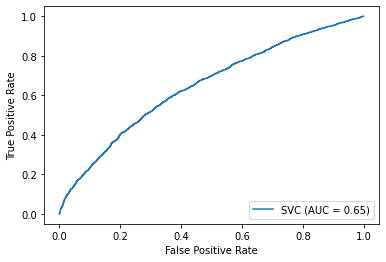

In [47]:
# BOW
plot_roc_curve(svm_rbf_bow, RBF_SVM_cv_test_reviews.toarray(), test_df['label'])

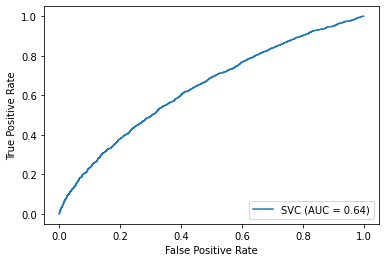

In [48]:
# TFIDF
plot_roc_curve(svm_rbf_tfidf, RBF_SVM_tv_test_reviews.toarray(), test_df['label'])

# BERT


  BERT, published by Google, is pre-trained language model word representation which transforms each word into a vector with a fixed size of 768.</br>

  In this project, we tokenized each training data into sentences and computed the mean of BERT embedding of the sentences to present each training data.

  To utilize BERT embedding for two mentioned purposes, we have used Sentence Transformers library.


In [21]:
pip install -U sentence-transformers

     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 1.3MB 9.3MB/s 
     |████████████████████████████████| 2.9MB 52.0MB/s 
     |████████████████████████████████| 1.1MB 44.5MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101034 sha256=75a118c2c28c31491c68658db470847cd9aa00afbd5b08b3f8014372fc39b2a2
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0714b4409e42f7b7262a0969b23bd62351485cd40171246a9aa3a22762f0556e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [22]:
from sentence_transformers import SentenceTransformer
import pickle

In [23]:
bert_embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
bert_embedder.max_seq_length

100%|██████████| 245M/245M [00:16<00:00, 14.6MB/s]


128

In [24]:
bert_train_reviews = bert_embedder.encode(train_df['text'].tolist(), show_progress_bar=True)

bert_valid_reviews = bert_embedder.encode(valid_df['text'].tolist(), show_progress_bar=True)

bert_test_reviews = bert_embedder.encode(test_df['text'].tolist(), show_progress_bar=True)

#Store sentences & embeddings on disc
with open('train_bert.pkl', "wb") as fOut:
    pickle.dump({'text': train_df['text'].tolist(), 'bert': bert_train_reviews}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

with open('valid_bert.pkl', "wb") as fOut:
    pickle.dump({'text': valid_df['text'].tolist(), 'bert': bert_valid_reviews}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_bert.pkl', "wb") as fOut:
    pickle.dump({'text': test_df['text'].tolist(), 'bert': bert_test_reviews}, fOut, protocol=pickle.HIGHEST_PROTOCOL)


In [25]:
print(bert_train_reviews.shape)
print(bert_valid_reviews.shape)
print(bert_test_reviews.shape)

(40000, 768)
(5000, 768)
(5000, 768)


In [26]:
#Load text & bert from disc
with open('train_bert.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_text = stored_data['text']
    bert_train_reviews = stored_data['bert']

with open('valid_bert.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_text = stored_data['text']
    bert_valid_reviews = stored_data['bert']

with open('test_bert.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_text = stored_data['text']
    bert_test_reviews = stored_data['bert']

In [27]:
print(bert_train_reviews.shape)
print(bert_valid_reviews.shape)
print(bert_test_reviews.shape)

(40000, 768)
(5000, 768)
(5000, 768)


### BERT Naive Bayes

In [ ]:
#training the model
bnb = BernoulliNB()

#fitting the model for bert features
bnb_bert = bnb.fit(bert_train_reviews, train_df['label'])
print(bnb_bert)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [ ]:
#Predicting the model for bert
bnb_bert_predict = bnb.predict(bert_test_reviews)
print(bnb_bert_predict)

[0 0 0 ... 0 0 1]


In [ ]:
#Accuracy score for bag of words
bnb_bert_score = accuracy_score(test_df['label'], bnb_bert_predict)
print("bnb_bert_score :",bnb_bert_score)

bnb_bert_score : 0.7536


In [ ]:
#Classification report for bag of words 
bnb_bert_report = classification_report(test_df['label'], bnb_bert_predict, target_names=['Positive', 'Negative'])
print(bnb_bert_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      2495
    Negative       0.76      0.75      0.75      2505

    accuracy                           0.75      5000
   macro avg       0.75      0.75      0.75      5000
weighted avg       0.75      0.75      0.75      5000



In [ ]:
#confusion matrix for bag of words
bnb_cm_bert = confusion_matrix(test_df['label'], bnb_bert_predict, labels=[1,0])
print(bnb_cm_bert)

[[1875  630]
 [ 602 1893]]


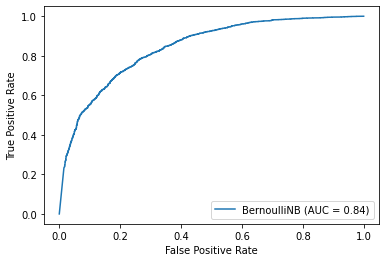

In [ ]:
# bert
plot_roc_curve(bnb_bert, bert_test_reviews, test_df['label'])

### BERT Linear SVM

In [58]:
#training the model
svm_linear = LinearSVC(verbose=1, max_iter=5000, loss='hinge')

#fitting the model for bert features
svm_linear_bert = svm_linear.fit(bert_train_reviews, train_df['label'])
print(svm_linear_bert)

[LibLinear]LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=1)


In [59]:
#Predicting the model for bert
svm_linear_bert_predict = svm_linear.predict(bert_test_reviews)
print(svm_linear_bert_predict)

[0 1 0 ... 0 0 1]


In [60]:
#Accuracy score for bag of words
svm_linear_bert_score = accuracy_score(test_df['label'], svm_linear_bert_predict)
print("svm_linear_bert_score :",svm_linear_bert_score)

svm_linear_bert_score : 0.8308


In [61]:
#Classification report for bag of words 
svm_linear_bert_report = classification_report(test_df['label'], svm_linear_bert_predict, target_names=['Positive', 'Negative'])
print(svm_linear_bert_report)

              precision    recall  f1-score   support

    Positive       0.83      0.82      0.83      2495
    Negative       0.83      0.84      0.83      2505

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [62]:
#confusion matrix for bag of words
svm_linear_cm_bert = confusion_matrix(test_df['label'], svm_linear_bert_predict, labels=[1,0])
print(svm_linear_cm_bert)

[[2098  407]
 [ 439 2056]]


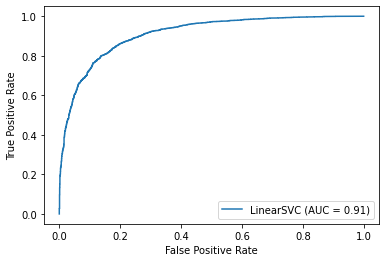

In [63]:
# bert
plot_roc_curve(svm_linear_bert, bert_test_reviews, test_df['label'])

### BERT SVM with RBF kernel

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
svm_rbf = SVC(kernel='rbf', verbose=True, probability=True)

rbf_parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001]
    }

rbf_grid = GridSearchCV(svm_rbf, rbf_parameters, refit = True, verbose = 3) 

# fitting the model for grid search 
rbf_grid.fit(bert_valid_reviews, valid_df['label']) 

print_results(rbf_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=1, gamma=0.1, score=0.619, total= 1.5min
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.615, total= 1.5min
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.605, total= 1.5min
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.619, total= 1.5min
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.621, total= 1.5min
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.802, total=  54.9s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.793, total=  54.7s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.798, total=  54.0s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.801, total=  54.8s
[CV] C=1, gamma=0.01 ........

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 89.5min finished


BEST PARAMS: {'C': 10, 'gamma': 0.001}

0.616 (+/-0.011) for {'C': 1, 'gamma': 0.1}
0.8 (+/-0.009) for {'C': 1, 'gamma': 0.01}
0.79 (+/-0.012) for {'C': 1, 'gamma': 0.001}
0.773 (+/-0.02) for {'C': 1, 'gamma': 0.0001}
0.636 (+/-0.019) for {'C': 10, 'gamma': 0.1}
0.796 (+/-0.028) for {'C': 10, 'gamma': 0.01}
0.801 (+/-0.02) for {'C': 10, 'gamma': 0.001}
0.791 (+/-0.01) for {'C': 10, 'gamma': 0.0001}
0.636 (+/-0.019) for {'C': 100, 'gamma': 0.1}
0.797 (+/-0.027) for {'C': 100, 'gamma': 0.01}
0.801 (+/-0.025) for {'C': 100, 'gamma': 0.001}
0.801 (+/-0.015) for {'C': 100, 'gamma': 0.0001}
0.636 (+/-0.019) for {'C': 1000, 'gamma': 0.1}
0.797 (+/-0.027) for {'C': 1000, 'gamma': 0.01}
0.783 (+/-0.034) for {'C': 1000, 'gamma': 0.001}
0.795 (+/-0.028) for {'C': 1000, 'gamma': 0.0001}


In [ ]:
# print best parameter after tuning 
print(rbf_grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(rbf_grid.best_estimator_) 

{'C': 10, 'gamma': 0.001}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)


In [ ]:
grid_predictions = rbf_grid.predict(bert_test_reviews) 
  
# print classification report 
print(classification_report(test_df['label'], grid_predictions)) 

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2495
           1       0.81      0.81      0.81      2505

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



In [34]:
#training the model
svm_rbf = SVC(kernel='rbf', verbose=True, C=10, gamma=0.001, max_iter=20000)

#fitting the model for bert features
svm_rbf_bert = svm_rbf.fit(bert_train_reviews, train_df['label'])
print(svm_rbf_bert)

[LibSVM]SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=20000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)


In [35]:
#Predicting the model for bert
svm_rbf_bert_predict = svm_rbf.predict(bert_test_reviews)
print(svm_rbf_bert_predict)

[0 0 0 ... 0 0 1]


In [36]:
#Accuracy score for bag of words
svm_rbf_bert_score = accuracy_score(test_df['label'], svm_rbf_bert_predict)
print("svm_rbf_bert_score :",svm_rbf_bert_score)

svm_rbf_bert_score : 0.8312


In [37]:
#Classification report for bag of words 
svm_rbf_bert_report = classification_report(test_df['label'], svm_rbf_bert_predict, target_names=['Positive', 'Negative'])
print(svm_rbf_bert_report)

              precision    recall  f1-score   support

    Positive       0.84      0.82      0.83      2495
    Negative       0.82      0.84      0.83      2505

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000



In [38]:
#confusion matrix for bag of words
svm_rbf_cm_bert = confusion_matrix(test_df['label'], svm_rbf_bert_predict, labels=[1,0])
print(svm_rbf_cm_bert)

[[2112  393]
 [ 451 2044]]


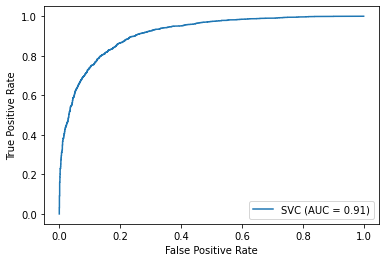

In [39]:
# bert
plot_roc_curve(svm_rbf_bert, bert_test_reviews, test_df['label'])

# Word2Vec

  Word2Vec consists of two models which are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures: Continuous Bag of Words and Skip Gram. The basic idea of Word2Vec is words that occur in similar context tend to be closer to each other in vector space. gensim library is used to generate word vectors in Python.

In [64]:
from gensim.models import Word2Vec

In [70]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [83]:
import itertools
def mean(z): # used for BERT (word version) and Word2Vec
    return sum(itertools.chain(z))/len(z)

In [84]:
def embeddToWord2Vec(text):
    words = word_tokenize(text)
    result = [w2v.wv[w] for w in words if w in w2v.wv.vocab]
    feature = [mean(x) for x in zip(*result)]
    return feature

In [72]:
def wordTokenize(text):
  return word_tokenize(text)

In [73]:
train_words = train_df['text'].apply(wordTokenize)

In [76]:
w2v = Word2Vec(train_words, min_count = 2, size = 100, window = 5)

In [89]:
w2v_train = train_df['text'].apply(embeddToWord2Vec)
w2v_valid = valid_df['text'].apply(embeddToWord2Vec)
w2v_test = test_df['text'].apply(embeddToWord2Vec)

w2v_train_reviews = np.asarray([x for x in w2v_train.transpose()])
w2v_valid_reviews = np.asarray([x for x in w2v_valid.transpose()])
w2v_test_reviews = np.asarray([x for x in w2v_test.transpose()])

In [90]:
print(w2v_train_reviews.shape)
print(w2v_valid_reviews.shape)
print(w2v_test_reviews.shape)

(40000, 100)
(5000, 100)
(5000, 100)


### W2V Naive Bayes

In [91]:
#training the model
bnb = BernoulliNB()

#fitting the model for w2v features
bnb_w2v = bnb.fit(w2v_train_reviews, train_df['label'])
print(bnb_w2v)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [92]:
#Predicting the model for w2v
bnb_w2v_predict = bnb.predict(w2v_test_reviews)
print(bnb_w2v_predict)

[0 0 0 ... 1 0 0]


In [93]:
#Accuracy score for bag of words
bnb_w2v_score = accuracy_score(test_df['label'], bnb_w2v_predict)
print("bnb_w2v_score :",bnb_w2v_score)

bnb_w2v_score : 0.724


In [94]:
#Classification report for bag of words 
bnb_w2v_report = classification_report(test_df['label'], bnb_w2v_predict, target_names=['Positive', 'Negative'])
print(bnb_w2v_report)

              precision    recall  f1-score   support

    Positive       0.70      0.77      0.74      2495
    Negative       0.75      0.68      0.71      2505

    accuracy                           0.72      5000
   macro avg       0.73      0.72      0.72      5000
weighted avg       0.73      0.72      0.72      5000



In [95]:
#confusion matrix for bag of words
bnb_cm_w2v = confusion_matrix(test_df['label'], bnb_w2v_predict, labels=[1,0])
print(bnb_cm_w2v)

[[1692  813]
 [ 567 1928]]


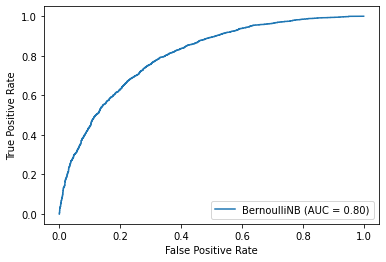

In [96]:
# w2v
plot_roc_curve(bnb_w2v, w2v_test_reviews, test_df['label'])

### W2V Linear SVM

In [103]:
#training the model
svm_linear = LinearSVC(verbose=1, max_iter=5000, loss='hinge')

#fitting the model for w2v features
svm_linear_w2v = svm_linear.fit(w2v_train_reviews, train_df['label'])
print(svm_linear_w2v)

[LibLinear]LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=1)


In [104]:
#Predicting the model for w2v
svm_linear_w2v_predict = svm_linear.predict(w2v_test_reviews)
print(svm_linear_w2v_predict)

[0 0 0 ... 0 0 1]


In [105]:
#Accuracy score for bag of words
svm_linear_w2v_score = accuracy_score(test_df['label'], svm_linear_w2v_predict)
print("svm_linear_w2v_score :",svm_linear_w2v_score)

svm_linear_w2v_score : 0.849


In [106]:
#Classification report for bag of words 
svm_linear_w2v_report = classification_report(test_df['label'], svm_linear_w2v_predict, target_names=['Positive', 'Negative'])
print(svm_linear_w2v_report)

              precision    recall  f1-score   support

    Positive       0.86      0.83      0.85      2495
    Negative       0.84      0.86      0.85      2505

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [107]:
#confusion matrix for bag of words
svm_linear_cm_w2v = confusion_matrix(test_df['label'], svm_linear_w2v_predict, labels=[1,0])
print(svm_linear_cm_w2v)

[[2162  343]
 [ 412 2083]]


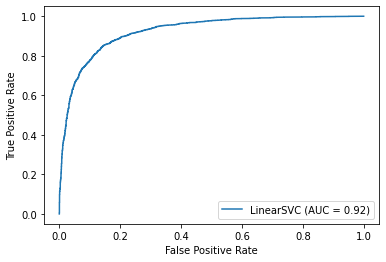

In [108]:
# w2v
plot_roc_curve(svm_linear_w2v, w2v_test_reviews, test_df['label'])

### W2V SVM with RBF kernel

In [109]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [110]:
svm_rbf = SVC(kernel='rbf', verbose=True, probability=True)

rbf_parameters = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001]
    }

rbf_grid = GridSearchCV(svm_rbf, rbf_parameters, refit = True, verbose = 3) 

# fitting the model for grid search 
rbf_grid.fit(w2v_valid_reviews, valid_df['label']) 

print_results(rbf_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=1, gamma=0.1, score=0.826, total=   7.7s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.842, total=   7.5s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV] ...................... C=1, gamma=0.1, score=0.839, total=   7.5s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.829, total=   7.5s
[CV] C=1, gamma=0.1 ..................................................
[LibSVM][CV] ...................... C=1, gamma=0.1, score=0.832, total=   7.4s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.821, total=   9.4s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.828, total=   9.4s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.819, total=   9.3s
[CV] C=1, gamma=0.01 .................................................
[LibSVM][CV] ..................... C=1, gamma=0.01, score=0.828, total=   9.4s
[CV] C=1, gamma=0.01 ........

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 13.2min finished


BEST PARAMS: {'C': 10, 'gamma': 0.01}

0.834 (+/-0.012) for {'C': 1, 'gamma': 0.1}
0.825 (+/-0.008) for {'C': 1, 'gamma': 0.01}
0.783 (+/-0.006) for {'C': 1, 'gamma': 0.001}
0.506 (+/-0.003) for {'C': 1, 'gamma': 0.0001}
0.832 (+/-0.009) for {'C': 10, 'gamma': 0.1}
0.84 (+/-0.012) for {'C': 10, 'gamma': 0.01}
0.823 (+/-0.012) for {'C': 10, 'gamma': 0.001}
0.784 (+/-0.005) for {'C': 10, 'gamma': 0.0001}
0.809 (+/-0.012) for {'C': 100, 'gamma': 0.1}
0.837 (+/-0.015) for {'C': 100, 'gamma': 0.01}
0.84 (+/-0.01) for {'C': 100, 'gamma': 0.001}
0.822 (+/-0.014) for {'C': 100, 'gamma': 0.0001}
0.795 (+/-0.022) for {'C': 1000, 'gamma': 0.1}
0.829 (+/-0.007) for {'C': 1000, 'gamma': 0.01}
0.837 (+/-0.015) for {'C': 1000, 'gamma': 0.001}
0.838 (+/-0.011) for {'C': 1000, 'gamma': 0.0001}


In [111]:
# print best parameter after tuning 
print(rbf_grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(rbf_grid.best_estimator_) 

{'C': 10, 'gamma': 0.01}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)


In [112]:
grid_predictions = rbf_grid.predict(w2v_test_reviews) 
  
# print classification report 
print(classification_report(test_df['label'], grid_predictions)) 

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2495
           1       0.84      0.86      0.85      2505

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [125]:
#training the model
svm_rbf = SVC(kernel='rbf', verbose=True, C=10, gamma=0.01)

#fitting the model for w2v features
svm_rbf_w2v = svm_rbf.fit(w2v_train_reviews, train_df['label'])
print(svm_rbf_w2v)

[LibSVM]SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)


In [126]:
#Predicting the model for w2v
svm_rbf_w2v_predict = svm_rbf.predict(w2v_test_reviews)
print(svm_rbf_w2v_predict)

[0 0 0 ... 0 0 1]


In [127]:
#Accuracy score for bag of words
svm_rbf_w2v_score = accuracy_score(test_df['label'], svm_rbf_w2v_predict)
print("svm_rbf_w2v_score :",svm_rbf_w2v_score)

svm_rbf_w2v_score : 0.856


In [128]:
#Classification report for bag of words 
svm_rbf_w2v_report = classification_report(test_df['label'], svm_rbf_w2v_predict, target_names=['Positive', 'Negative'])
print(svm_rbf_w2v_report)

              precision    recall  f1-score   support

    Positive       0.87      0.84      0.85      2495
    Negative       0.85      0.87      0.86      2505

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



In [129]:
#confusion matrix for bag of words
svm_rbf_cm_w2v = confusion_matrix(test_df['label'], svm_rbf_w2v_predict, labels=[1,0])
print(svm_rbf_cm_w2v)

[[2177  328]
 [ 392 2103]]


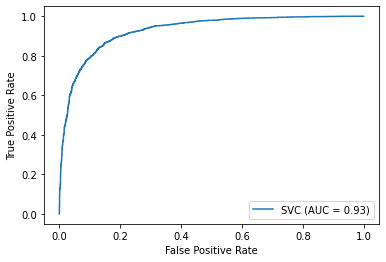

In [130]:
# w2v
plot_roc_curve(svm_rbf_w2v, w2v_test_reviews, test_df['label'])

  We observe the results of our classifiers with comuted statistics and ROC curves.

Thank you.